# Excerpts from the Handbook 

Formula for Naive Bayes Classifier: 

$$ P(y|x_1,\ x_2,\ \ldots, x_j) = \frac{  P(x_1,\ x_2,\ \ldots, x_j|\ y) \cdot P(y) }{P(x_1,\ x_2,\ \dots, x_j)}$$

There are two important things to note about naive bayes classifiers. First, for each feature in the data, we have to assume the statistical distribition of the likelihood, $P(x_j|y)$. The common distributions are the normal (Gaussian), multinomial, and Bernoulli distributions. The distribution chosen is often determined by the nature of features (continuous, binary, etc.) Second, naive bayes gets its name because we assume that each feature, and its resulting likelihood, is independent. This "naive" assumption is frequently wrong, yet in practice does little to prevent building high-quaility classifier.

Different types of naive Bayes classifier rest on different naive assumptions about the data, and we will examine a few of these in the following sections:



In [26]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Gaussian Naive Bayes

The easiest naive Bayes classifier is Gaussian naive Bayes. In this classifier, the assumption is that the data from each label is drawn from a single Gaussian distribution. Let use make_blobs library from sci-kit learn to generate the data points.

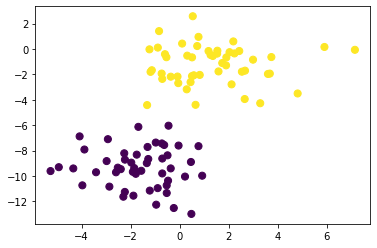

In [27]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers = 2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

One fast way to create a simple model is to assume that the data is described by a Gaussian distribution with no covariance between dimensions. This model can be fit by simply finding the mean and the standard deviation of the points within each label, which is all you need to define such a distribution. The following code generate the circles around the mean of the two different feature.

[(-8.0, 8.0), (-15.0, 5.0)]

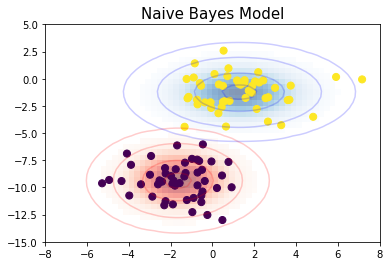

In [28]:
# Using the X and y defined in the first code cell
fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
ax.set_title('Naive Bayes Model', size = 15)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 /std ** 2 ).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                cmap = color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
                levels = [0.01, 0.1, 0.5, 0.9],
                colors = color, alpha = 0.2)

ax.set(xlim = xlim, ylim = ylim)

The ellipses here represent the Gaussian generative model for each label, with larger probability towards the center of the ellipses. With this generative model in place for each class, we have a simple recipe to compute the likelihood $P(\text{features}| L_1)$ for any data point, and thus we can quickly compute the posterior ratio $P(y|x_1,\ x_2, \dots , x_j)$ and determine which label is the most probable for a given point.

This procedure is implemented in the Scikit-Learn's *sklearn.naive_bayes.GaussianNB* estimator:

In [29]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X,y)

GaussianNB()

Generating some new data points and predicting their label

In [36]:
rng = np.random.RandomState(0)     # function to generate random numbers
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)    # creates a new array of size 2x2000.
ynew = model.predict(Xnew)     # Predicts the values from the GaussianNB Model

[[ 1.68338905 -1.12659141]
 [ 2.43868727 -4.19210271]
 [-0.06883281 -2.37390596]
 ...
 [-4.32134532 -7.70649139]
 [ 0.08823081  0.94005305]
 [ 7.05928655 -8.44990818]]


*RandomState* expose a number of methods for generating random numbers drawn from a variety of probability distributions. In addition to the distribution-specific arguments, each method takes a keyword argument size that defaults to None. If size is *None*, then a single value is generated and returned. If size is an *integer*, then a 1-D array filled with generated values is returned

Now we can plot this new data to get an idea of where the decision boundary is:

(-5.890554373486014,
 7.777566725032841,
 -13.775943665162341,
 3.3634536696825847)

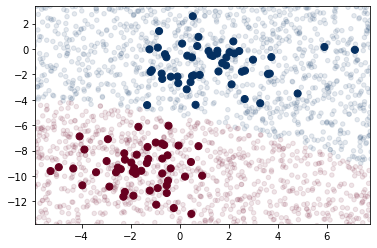

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap = 'RdBu')    # Plots the scatter plot of the X's
lim = plt.axis()                                           # 
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)   # alpha make the new data points transparent
plt.axis(lim)                                              # Plot in a way such that data points covers the whole plot while plotting

We see a slightly curved boundary in the classification - in general, the boundary in Gaussian naive Bayes is quadratic.

A nice piece of this Bayesian formalism is that it naturally allows for probabilistic classification, which we can compute the probability using the predict *predict_proba* method:

In [54]:
yprob = model.predict_proba(Xnew)
#print(yprob)
yprob = yprob[-8:].round(2)
print(yprob)

[[0.89 0.11]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.   1.  ]
 [0.15 0.85]]


The columns gives the posterior probabilities of the first and second label, respecitively. If you are looking for estimates of uncertainty in your classification, Bayesian approches like this can be useful approch.

Of course, the final classification will only be as good as the model assumptions that lead to it, which is why Gaussian naive Bayes often does not produce very good results. Still, in many cases-especially as the number of features becomes large - this assumption is not detrimental enough to prevent Gaussian naive Bayes from being a useful method.

## Multinomial Naive Bayes

The Gaussian assumption just described is by no means the only simple assumption that could be used to specify the generative distribution for each label. Another useful example is multinomial naive Bayes, where the features are assumed to be generated from a simple multinomial distribution. The multinomial distribution describes the probability of observing counts among a number of categories, and thus multinomial naive Bayes is most appropriate for features that represents counts or count rates.

The idea is precisely the same as before, except that instead of modelling the data distribution with the best-fit Gaussian, we model the data distribution with a best-fit multinomial distribution.

### Example: Classifying Text

One place where multinomial naive Bayes is often used is text classification, where the features are related to word counts or frequencies within the documents to be classified. Here we will use the sparse word count feature from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [55]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [56]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [57]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers. For this we will use the TF-IDF vectorize, and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Convert a collection of raw documents to a matrix of TF-IDF features.

TF-IDF stands for term frequency-inverse document frequency and it is a measure, used in the fields of information retrieval (IR) and machine learning, that can quantify the importance or relevance of string representations (words, phrases, lemmas, etc)  in a document amongst a collection of documents (also known as a corpus).

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [67]:
model.fit(train.data, train.target)
labels = model.predict(test.data)
print(labels)

[2 0 1 ... 1 2 1]


Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estiamtor. For example, here is the confusion matrix between the true and predicted labels for the test data:

Text(91.68, 0.5, 'predicted label')

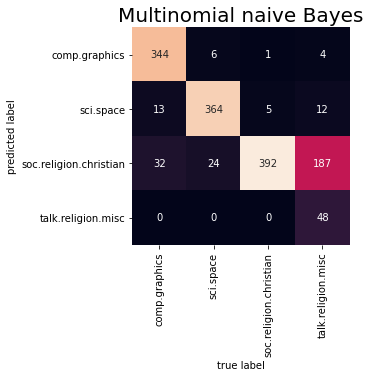

In [77]:
from sklearn.metrics import confusion_matrix
plt.title('Multinomial naive Bayes', size = 20)
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
        xticklabels=train.target_names, yticklabels=train.target_names)

plt.xlabel('true label')
plt.ylabel('predicted label')

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about relegion and talk about Christianity. This is perhaps an expected area of confusion.

The very cool thing here is that we now have the tools to determine the category for any string, using the *predict()* method of this pipeline. Here is a quick utility function that will return the prediction for a single string:

In [78]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]


In [79]:
predict_category('sending a payload to the ISS')

'sci.space'

In [80]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [91]:
predict_category('Heaven')

'soc.religion.christian'

Remeber that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking. Even a vary naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

### When to use Naive Bayes

Because naive Bayesian classifier makes such stringent assumptions about the data, they will generally not perform as well as a more complicated model. That said, they have several advantages:
* They are extremely fast for both training and predictions
* They provide straightforward probabilistic prediction
* They are often very easily interpretable
* They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification. If it performs suitably, then congratulations: you have a very fast very interpretable classifier for your problem. If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:
* When the naive assumptions actually match the data (very rare in practice)
* For very well-separated categories, when model complexity is less important
* For very high-dimensional data, when model complexity is less important

The last two points seem distinct but they actually are related: as the dimension of a dataset grows, it is much less likely for any points to be found close together (after all, they must be close in every single dimension to be close overall). This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information. For this reason, simplistic classifier like naive Bayes tend to work as well or better than more complicated classifiers as dimensionality grows: once you have enough data, even a simple model can be very powerful.